In [82]:

#Klaudia Kromołowska - kromolowska@student.agh.edu.pl

#Jędrzej Kosior - jkosior@student.agh.edu.pl

In [83]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [84]:
!pip install sounddevice
!pip install librosa
!pip install kaggle
!pip install matplotlib
!pip install keras
!pip install tensorflow

In [85]:
DATA_DIR = "alldatas"
AUDIO_ARCHIVE = "pliki_S_R.tar.gz"
BEST_MODEL_PATH = "model/best_model_{model_label}.hdf5"
TEST_MODE = True

In [86]:
mkdir {DATA_DIR} && tar -xf {AUDIO_ARCHIVE} -C {DATA_DIR}

A subdirectory or file alldatas already exists.


In [87]:
train_audio_path = 'alldatas/'
labels=os.listdir(train_audio_path)
words = os.listdir(DATA_DIR)
print(words)

['happy', 'one', 'six', 'up', 'wow']


In [88]:
#PREPROCESSING

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

happy
one
six
up
wow


In [89]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [90]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [91]:
#2D na 3D
all_wave = np.array(all_wave).reshape(-1,8000,1)


In [92]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [93]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

def build_model(unique_labels):

    K.clear_session()

    inputs = Input(shape=(8000,1))

    #First Conv1D layer
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Third Conv1D layer
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Fourth Conv1D layer
    conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Flatten layer
    conv = Flatten()(conv)

    #Dense Layer 1
    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    #Dense Layer 2
    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    outputs = Dense(len(unique_labels), activation='softmax')(conv)

    model = Model(inputs, outputs)
    return model

model=build_model(labels)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [94]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#TRENING I TESTOWANIE NA ZBIORZE WALIDACYJNYM 
history=model.fit(x_tr, y_tr ,epochs=3, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))



Epoch 1/3
236/236 [==============================] - 65s 269ms/step - loss: 1.5200 - accuracy: 0.3059 - val_loss: 1.1050 - val_accuracy: 0.5339

Epoch 00001: val_accuracy improved from -inf to 0.53390, saving model to best_model.hdf5
Epoch 2/3
236/236 [==============================] - 59s 252ms/step - loss: 1.0597 - accuracy: 0.5600 - val_loss: 0.9647 - val_accuracy: 0.6006

Epoch 00002: val_accuracy improved from 0.53390 to 0.60064, saving model to best_model.hdf5
Epoch 3/3
236/236 [==============================] - 63s 266ms/step - loss: 0.8902 - accuracy: 0.6358 - val_loss: 0.7296 - val_accuracy: 0.7722

Epoch 00003: val_accuracy improved from 0.60064 to 0.77225, saving model to best_model.hdf5


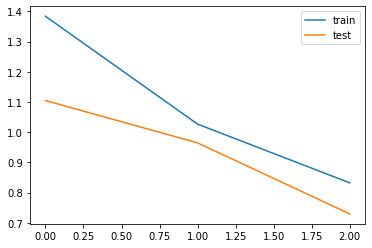

In [95]:
#WYKRES DIAGNOSTYCZNY

from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#ŁADOWANIE MODELU

from keras.models import load_model
model=load_model('best_model.hdf5')

In [96]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [97]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: one


In [98]:

print("Text:",predict(samples))

Text: one


In [130]:
#MACIERZ POMYLEK
from sklearn.model_selection import train_test_split

test_set_sizes = [40] if TEST_MODE else [500, 600, 800, 1000]

X_tr, X_test, Y_tr, Y_test = train_test_split(all_label,
                                              all_wave,stratify=all_label,
                                              test_size = 0.2,
                                              random_state=666,
                                              shuffle=True)

prob = predict(samples)
pred = [classes[np.argmax(prob[0])] for sample in X_test]

original_labels = [classes[np.argmax(label)] for label in Y_test] 


cm = confusion_matrix(original_labels, pred, labels = classes)
print(cm)

IndexError: list index out of range